# Import libraries
This notebook is built based on https://github.com/mginolin/standax/tree/main/notebooks from Madeleine Ginolin

In [39]:
import numpy as np
import pandas as pd
from standax import standardisation
from astropy.cosmology import Planck18
from scipy import stats
import jax.numpy as jnp

# Import sample

In [40]:
df = pd.read_parquet("../data/inference_data_frame.parquet")
new_cols = ["cov_mag_c", "cov_mag_x1", "cov_x1_c"]
df[new_cols] = 0.0
df = df.rename(columns={"magobs": "mag"})
df = df.rename(columns={"magobs_err": "mag_err"})
df = df.rename(columns={"prompt": "h_low"})
df = df.rename(columns={"localcolor": "localrestframe_gz"})
df = df.rename(columns={"localcolor_err": "localrestframe_gz_err"})
df = df.rename(columns={"mass": "globalmass"})
df = df.rename(columns={"mass_err": "globalmass_err"})


df["h_low"] = stats.norm.cdf(1, loc=df["localrestframe_gz"], scale=df["localrestframe_gz_err"])
df["h_low_err"] = 1e-4

In [41]:
print(df.head())

         mag   mag_err        x1    x1_err         c     c_err  \
0  18.019849  0.044450 -0.852072  0.138463 -0.053650  0.038890   
1  17.760927  0.032031 -0.090054  0.088482 -0.008850  0.031588   
2  16.180737  0.041959  1.044635  0.311451 -0.013091  0.033970   
3  17.947753  0.044842 -2.491485  0.405941  0.006570  0.030875   
4  18.218166  0.033734 -1.940780  0.435881  0.038687  0.031108   

   localrestframe_gz  localrestframe_gz_err  globalmass  globalmass_err  \
0           1.365223               0.032305    9.948320        0.101503   
1           0.280190               0.335420    9.575358        0.101509   
2           0.539824               0.091101    7.875948        0.101285   
3           1.463736               0.024009   10.401221        0.101448   
4           1.505958               0.042382   11.093515        0.101356   

          h_low        z  cov_mag_c  cov_mag_x1  cov_x1_c  h_low_err  
0  6.153748e-30  0.05635        0.0         0.0       0.0     0.0001  
1  9.84063

In [42]:
data_to_fit = df[["mag", "mag_err", "x1", "x1_err", "c", "c_err", "h_low", "h_low_err",
                    "cov_mag_c", "cov_mag_x1", "cov_x1_c"]].dropna()

residuals = df['mag'] - Planck18.distmod(df['z']).value + 19.3
data_to_fit['mag'] = residuals

In [43]:
print(data_to_fit.head())

        mag   mag_err        x1    x1_err         c     c_err         h_low  \
0  0.242946  0.044450 -0.852072  0.138463 -0.053650  0.038890  6.153748e-30   
1 -0.051762  0.032031 -0.090054  0.088482 -0.008850  0.031588  9.840633e-01   
2  0.135233  0.041959  1.044635  0.311451 -0.013091  0.033970  9.999998e-01   
3  0.548416  0.044842 -2.491485  0.405941  0.006570  0.030875  1.993232e-83   
4  0.485757  0.033734 -1.940780  0.435881  0.038687  0.031108  3.754559e-33   

   h_low_err  cov_mag_c  cov_mag_x1  cov_x1_c  
0     0.0001        0.0         0.0       0.0  
1     0.0001        0.0         0.0       0.0  
2     0.0001        0.0         0.0       0.0  
3     0.0001        0.0         0.0       0.0  
4     0.0001        0.0         0.0       0.0  


# Fit sample with total chi2

In [44]:
init = {"coefs": jnp.asarray([-0.273, -0.085,  3.3, 0.17], dtype="float32"),
        "xbreak": jnp.asarray(-0.5, dtype="float32")}

(best_params_l, sigmaint_l, mcmc_l), this_l = standardisation.standardise_snia(data_to_fit,
                                                      init=init, 
                                                      xkeys=["x1", "c", "h_low"], 
                                                      sigmaint_guess=0.15, 
                                                      model="brokenlinear", 
                                                      num_samples=1000,
                                                      nfetch=0, verbose=True,
                                                     lmbda=1e4, fit_method="tncg")

fitting using <function fit_tncg at 0x7f48203067a0> using guess: {'xbreak': Array(-0.5, dtype=float32), 'offset': Array(0., dtype=float32), 'x_model': Array([[-8.5207212e-01, -9.0054251e-02,  1.0446353e+00, ...,
        -2.0392497e+00, -1.5618062e+00, -4.3110338e-01],
       [-5.3650256e-02, -8.8498611e-03, -1.3090929e-02, ...,
        -1.0678776e-01,  6.3621241e-01,  1.7860316e-02],
       [ 6.1537483e-30,  9.8406333e-01,  9.9999976e-01, ...,
         1.6342096e-29,  8.6059487e-07,  6.6155466e-23]], dtype=float32), 'coefs': Array([-0.273, -0.085,  3.3  ,  0.17 ], dtype=float32)}
 -> fitting options {'lmbda': 10000.0, 'sigmaint': 0.15}
running mcmc now with 1000 sampler (end 10% warmup)
using sigmaint = 0.15 for mcmc


In [45]:
# alpha = best_params_l['coefs'][0]
# chain_alpha = mcmc_l.get_samples()['coefs'][:,0]
# alpha_err = np.sqrt(np.sum((chain_alpha-alpha)**2)/len(chain_alpha))
# beta = best_params_l['coefs'][1]
# chain_beta = mcmc_l.get_samples()['coefs'][:,1]
# beta_err = np.sqrt(np.sum((chain_beta-beta)**2)/len(chain_beta))
# step = best_params_l['coefs'][2]
# chain_step = mcmc_l.get_samples()['coefs'][:,2]
# step_err = np.sqrt(np.sum((chain_step-step)**2)/len(chain_step))
# offset = best_params_l['offset']
# chain_offset = mcmc_l.get_samples()['offset']
# offset_err = np.sqrt(np.sum((chain_offset-offset)**2)/len(chain_offset))

In [46]:
alpha_low = best_params_l['coefs'][0]
chain_alpha_low = mcmc_l.get_samples()['coefs'][:,0]
alpha_low_err = np.sqrt(np.sum((chain_alpha_low-alpha_low)**2)/len(chain_alpha_low))
alpha_high = best_params_l['coefs'][1]
chain_alpha_high = mcmc_l.get_samples()['coefs'][:,1]
alpha_high_err = np.sqrt(np.sum((chain_alpha_high-alpha_high)**2)/len(chain_alpha_high))
beta = best_params_l['coefs'][2]
chain_beta = mcmc_l.get_samples()['coefs'][:,2]
beta_err = np.sqrt(np.sum((chain_beta-beta)**2)/len(chain_beta))
step = best_params_l['coefs'][3]
chain_step = mcmc_l.get_samples()['coefs'][:,3]
step_err = np.sqrt(np.sum((chain_step-step)**2)/len(chain_step))
offset = best_params_l['offset']
chain_offset = mcmc_l.get_samples()['offset']
offset_err = np.sqrt(np.sum((chain_offset-offset)**2)/len(chain_offset))
xbreak = best_params_l['xbreak']
chain_xbreak = mcmc_l.get_samples()['xbreak']
xbreak_err = np.sqrt(np.sum((chain_xbreak-xbreak)**2)/len(chain_xbreak))

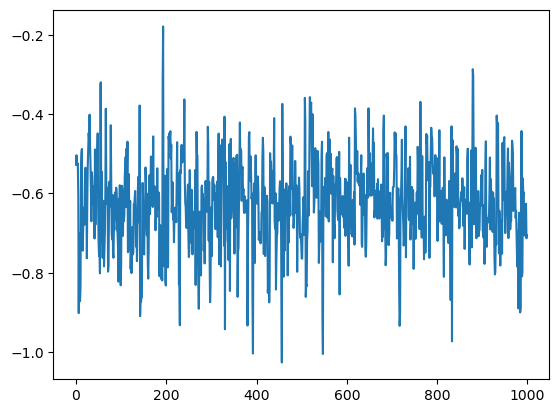

In [47]:
import matplotlib.pyplot as plt
plt.plot(chain_xbreak)
plt.show()

In [48]:
# Print parameters with errors in a clear table-like format
print(f"{'Parameter':<10} {'Value':>10} {'Error':>10}")
# print(f"{'alpha':<10} {alpha:>10.4f} {alpha_err:>10.4f}")
print(f"{'offset':<10} {offset:>10.4f} {offset_err:>10.4f}")
print(f"{'alpha low':<10} {alpha_low:>10.4f} {alpha_low_err:>10.4f}")
print(f"{'alpha high':<10} {alpha_high:>10.4f} {alpha_high_err:>10.4f}")
print(f"{'beta':<10} {beta:>10.4f} {beta_err:>10.4f}")
print(f"{'sigmaint':<10} {sigmaint_l[-1]:>10.4f}     unkown")

Parameter       Value      Error
offset        -0.1514     0.0315
alpha low     -0.2928     0.0206
alpha high    -0.0646     0.0142
beta           3.2768     0.0446
sigmaint       0.1500     unkown


In [49]:
samples = np.vstack([chain_alpha_low, chain_alpha_high, chain_beta, chain_offset, chain_step*1.3]).T #factor on chain step for contamination correction

## Save posterior

In [50]:
np.save("../data/results/standax_posterior.npy", samples)